# Prepare Required Files and Dependencies

Full dataset is available at [https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg](https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg)

In [1]:
!git clone https://github.com/dmc27/missing_pixels.git

fatal: Too many arguments.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    --reject-shallow      don't clone shallow repository
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    --recursive ...       alias of --recurse-submodules
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --refere

In [2]:
from os import listdir
from os.path import isfile
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, add, Softmax, AveragePooling2D, \
    Dense, Input, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

from utils import *

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

random.seed(42)

# Data Preparation

In [4]:
img_path = "datasets"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
img_fnames = random.choices(img_fnames, k=1000)
print(img_fnames[:20])

['3527b667-4423-4fa5-bbdc-87857dd370f2.JPEG', '4cff3be4-dded-4b0a-97e8-abc0a3a964bf.JPEG', '42bf257b-e7eb-4c92-8774-1a7556282f4b.JPEG', '0580aed6-0069-4931-a9ab-af0c500c19a6.JPEG', 'bc88044b-adab-4f66-a5a4-b8b05dc83df2.JPEG', '5360e0a5-b441-4ba1-9565-8abda2ed3c9c.JPEG', '9db5086c-bbf0-46ea-8029-728f64291d39.JPEG', '166e1c7d-8008-435b-b9f0-90a684f3732e.JPEG', '6a18e5cd-3498-46f7-9c8a-b4011e1792d4.JPEG', 'a33c2a76-043f-4d2a-b18e-215626038746.JPEG', 'ed4123a4-ec53-49c2-adf4-7e125b6f0056.JPEG', '63f3f0d4-1554-49b7-a52b-896a300b484c.JPEG', '32cef872-6eb1-4295-abc1-4ab169284d5d.JPEG', '0bec73d2-61f9-4c15-bb18-fc8755201a71.JPEG', '7ea64000-424c-4063-8987-19450c42aec1.JPEG', '4d237abb-f780-442e-8d91-b26b8caa2fcd.JPEG', 'cfaf801e-6f3f-45de-880e-8b81c7190477.JPEG', '637a54ef-72ea-4e68-8339-05379bbc37be.JPEG', '871440c1-b10c-4afa-a4ed-8951b7e39b03.JPEG', 'f30572b2-5c1a-4a0a-bf4e-23b22bb2aeba.JPEG']


In [5]:
image_patches = []
targets = []

for img_fname in img_fnames:
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = img.astype(np.float64)

    for i in range(0, img.shape[0], BLOCK_SIZE):
        for j in range(0, img.shape[1], BLOCK_SIZE):
            patch = img[i:i + BLOCK_SIZE, j:j + BLOCK_SIZE]
            targets.append(patch[3:5, 3:5].flatten())

            patch[3:5, 3:5] = 0.0
            image_patches.append(patch)

In [6]:
X_train = np.array(image_patches) / 255.0
y_train = np.array(targets) / 255.0

In [7]:
X_train = X_train.reshape(-1, BLOCK_SIZE, BLOCK_SIZE, 1)

# Modeling

Code adaption from https://github.com/Haikoitoh/paper-implementation/blob/main/MobileNetV2.ipynb

## Architecture

In [8]:
def expansion_block(x, t, filters, block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t * filters
    x = Conv2D(total_filters, 1, padding='same', use_bias=False, name=prefix + 'expand')(x)
    x = BatchNormalization(name=prefix + 'expand_bn')(x)
    x = ReLU(6, name=prefix + 'expand_relu')(x)
    return x


def depthwise_block(x, stride, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3, strides=(stride, stride), padding='same', use_bias=False, name=prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix + 'dw_bn')(x)
    x = ReLU(6, name=prefix + 'dw_relu')(x)
    return x


def projection_block(x, out_channels, block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels, kernel_size=1, padding='same', use_bias=False, name=prefix + 'compress')(x)
    x = BatchNormalization(name=prefix + 'compress_bn')(x)
    return x

In [9]:
def Bottleneck(x, t, filters, out_channels, stride, block_id):
    y = expansion_block(x, t, filters, block_id)
    y = depthwise_block(y, stride, block_id)
    y = projection_block(y, out_channels, block_id)
    if y.shape[-1] == x.shape[-1]:
        y = add([x, y])
    return y

In [10]:
def MobileNetV2(input_image=(224, 224, 3), n_classes=1000):
    input = Input(input_image)

    x = Conv2D(32, kernel_size=3, strides=(2, 2), padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)

    # 17 Bottlenecks

    x = depthwise_block(x, stride=1, block_id=1)
    x = projection_block(x, out_channels=16, block_id=1)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=24, stride=2, block_id=2)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=24, stride=1, block_id=3)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=32, stride=2, block_id=4)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=32, stride=1, block_id=5)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=32, stride=1, block_id=6)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=2, block_id=7)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=8)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=9)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=64, stride=1, block_id=10)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=11)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=12)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=96, stride=1, block_id=13)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=160, stride=2, block_id=14)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=160, stride=1, block_id=15)
    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=160, stride=1, block_id=16)

    x = Bottleneck(x, t=6, filters=x.shape[-1], out_channels=320, stride=1, block_id=17)

    #1*1 conv
    x = Conv2D(filters=1280, kernel_size=1, padding='same', use_bias=False, name='last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6, name='last_relu')(x)

    #AvgPool 7*7
    x = GlobalAveragePooling2D(name='global_average_pool')(x)

    output = Dense(n_classes, activation='sigmoid')(x)

    model = Model(input, output)

    return model

In [11]:
model_fname = "models/model.mobilenet.imagenet.h5"

model = MobileNetV2((BLOCK_SIZE, BLOCK_SIZE, 1), NUM_OUT_NODES)

model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["accuracy"])

model.summary()

2023-07-20 15:27:01.550202: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-07-20 15:27:01.550221: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-07-20 15:27:01.550224: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-07-20 15:27:01.550256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-20 15:27:01.550271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 4, 4, 32)             288       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 4, 4, 32)             128       ['conv2d[0][0]']              
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 4, 4, 32)             0         ['conv1_bn[0][0]']        

## Training

In [ ]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
                             save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=450, batch_size=256,
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/450


2023-07-20 15:27:03.515288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


224/225 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.2733

2023-07-20 15:27:17.267117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 0.02003, saving model to models/model.mobilenet.imagenet.h5
225/225 [==============================] - 16s 46ms/step - loss: 0.0200 - accuracy: 0.2732 - val_loss: 0.0733 - val_accuracy: 0.2463
Epoch 2/450
225/225 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.2988
Epoch 2: loss improved from 0.02003 to 0.01366, saving model to models/model.mobilenet.imagenet.h5
225/225 [==============================] - 9s 42ms/step - loss: 0.0137 - accuracy: 0.2988 - val_loss: 0.0738 - val_accuracy: 0.2992
Epoch 3/450
225/225 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.3077
Epoch 3: loss improved from 0.01366 to 0.01258, saving model to models/model.mobilenet.imagenet.h5
225/225 [==============================] - 9s 41ms/step - loss: 0.0126 - accuracy: 0.3077 - val_loss: 0.0548 - val_accuracy: 0.2414
Epoch 4/450
224/225 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.3260
Epoch 4: loss impr

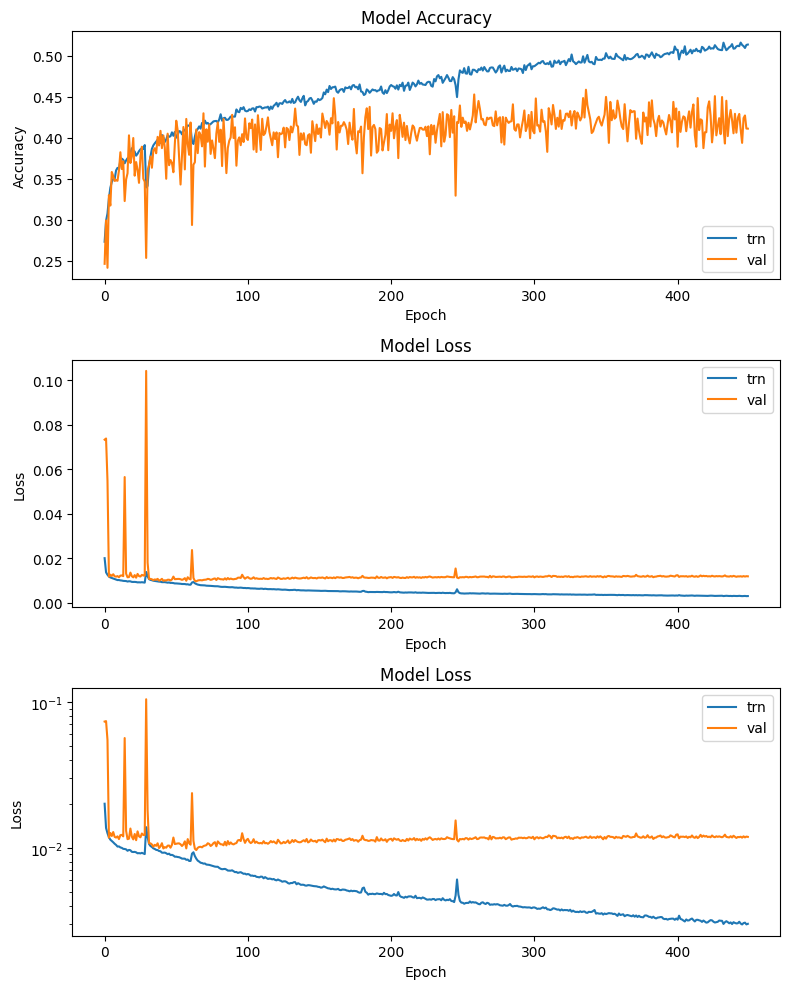

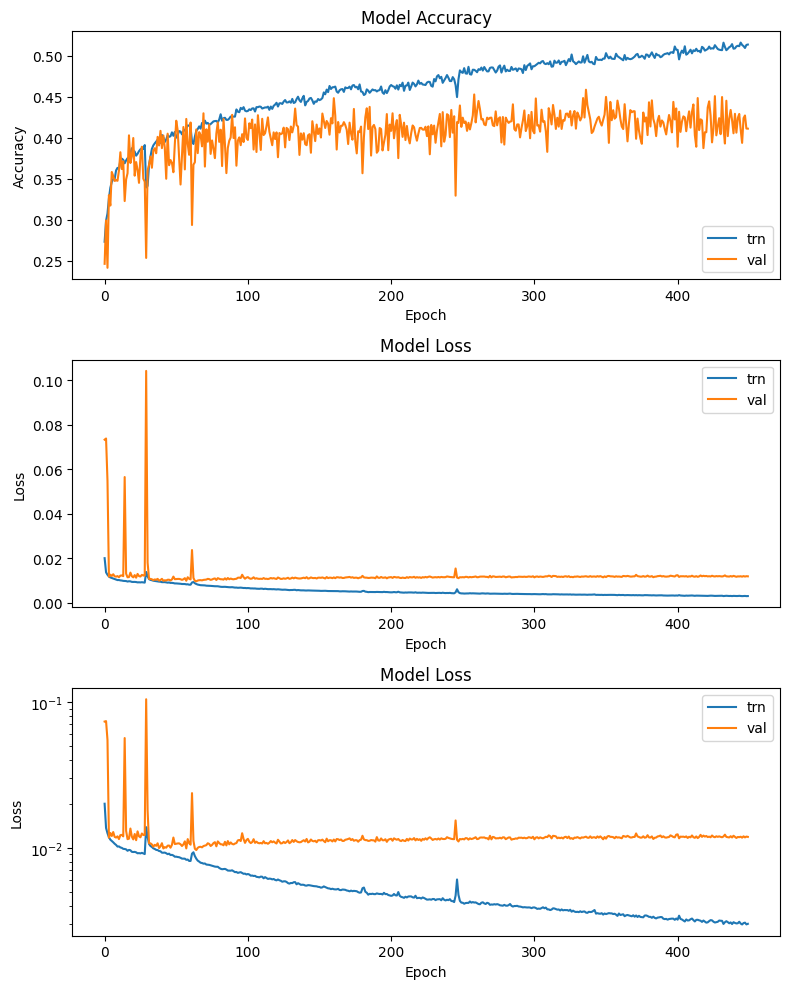

In [15]:
plot_training_history(history)

2023-07-20 16:48:22.234152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
MSE = 17.59


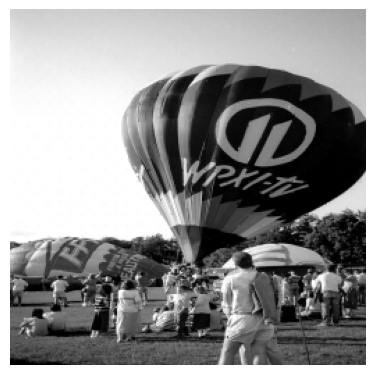

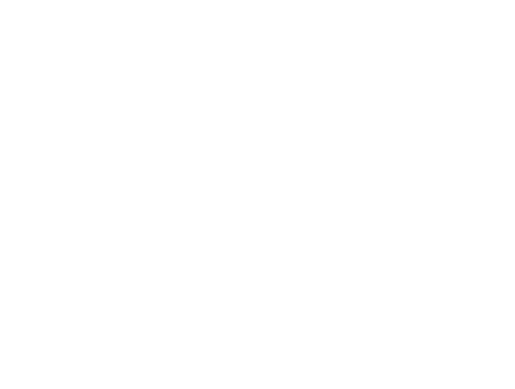

In [ ]:
evaluate_cnn(model)